## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import shap
plt.style.use('seaborn-v0_8')

C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Dataset

In [2]:
# Load dataset

file_path = r"C:\Users\Hp\OneDrive\Documents\Projects\Enhanced_Global_Internet_Adoption_Monthly 2015-2025.csv"
df = pd.read_csv(file_path)

# Quick inspection
print("First 5 Rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nUnique Values:")
print(df[['Country', '5G_Rollout_Status']].nunique())
print("\nSummary Statistics:")
print(df.describe())


First 5 Rows:
   Country      Date  Population  Internet_Penetration (%)  \
0  Algeria  1/1/2015    25258314                 37.436774   
1  Algeria  2/1/2015    25258314                 37.484286   
2  Algeria  3/1/2015    25258314                 37.629677   
3  Algeria  4/1/2015    25258314                 37.257667   
4  Algeria  5/1/2015    25258314                 37.492258   

   Broadband_Speed (Mbps)  Mobile_Broadband_Speed (Mbps)  \
0               46.839032                       8.533871   
1               47.227500                       8.687500   
2               47.436129                       8.852903   
3               47.500000                       9.058333   
4               47.659677                       8.886452   

   GDP_Per_Capita (USD)  Education_Attainment_Index (%)  \
0           5327.303548                       45.489677   
1           5331.729286                       45.555714   
2           5342.169032                       45.608710   
3           5354

## Plot of Targets

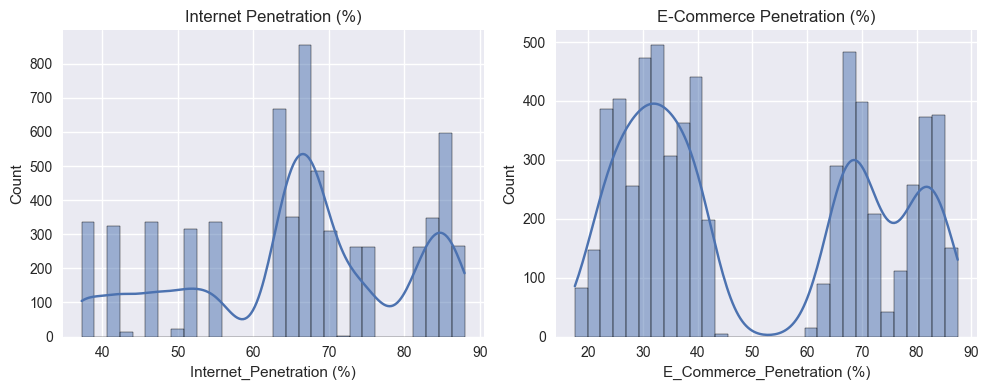

In [3]:

# Plot distribution of targets
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['Internet_Penetration (%)'], bins=30, kde=True)
plt.title('Internet Penetration (%)')
plt.subplot(1, 2, 2)
sns.histplot(df['E_Commerce_Penetration (%)'], bins=30, kde=True)
plt.title('E-Commerce Penetration (%)')
plt.tight_layout()
plt.show()

## Preprocessing

In [4]:
# Handle missing values
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    elif df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical variables
df['Country_Encoded'] = LabelEncoder().fit_transform(df['Country'])
df['5G_Rollout_Status_Encoded'] = LabelEncoder().fit_transform(df['5G_Rollout_Status'])
df = df.drop(['Country', '5G_Rollout_Status'], axis=1)

# Convert Date to numerical features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df = df.drop('Date', axis=1)

# Define features and targets
X = df.drop(['Internet_Penetration (%)', 'E_Commerce_Penetration (%)'], axis=1)
y_internet = df['Internet_Penetration (%)']
y_ecommerce = df['E_Commerce_Penetration (%)']

# Scale features
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data (70-20-10)
X_train, X_temp, y_internet_train, y_internet_temp = train_test_split(X_scaled, y_internet, test_size=0.3, random_state=42)
X_val, X_test, y_internet_val, y_internet_test = train_test_split(X_temp, y_internet_temp, test_size=0.33, random_state=42)
_, _, y_ecommerce_train, y_ecommerce_temp = train_test_split(X_scaled, y_ecommerce, test_size=0.3, random_state=42)
_, _, y_ecommerce_val, y_ecommerce_test = train_test_split(X_temp, y_ecommerce_temp, test_size=0.33, random_state=42)

# Save preprocessed data
df.to_csv('preprocessed_internet_adoption.csv', index=False)

# Verify splits
print("Data Split Shapes:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Data Split Shapes:
Train: (4445, 27), Val: (1276, 27), Test: (629, 27)


## Feature Engineering

In [5]:
# Feature Engineering
# 1. Urban-to-Rural Ratio
df['Urban_Rural_Ratio'] = df['Urban_Population_Split (%)'] / (df['Rural_Population_Split (%)'] + 1e-6)

# 2. GDP per Capita Growth
df['GDP_per_Capita_Growth'] = df.groupby('Country_Encoded')['GDP_Per_Capita (USD)'].pct_change().fillna(0)

# 3. Time Since 5G Rollout
df['Years_Since_5G'] = df['Year'] * (df['5G_Rollout_Status_Encoded'] > 0).astype(int)

# 4. Speed Penetration Interaction
df['Speed_Penetration'] = df['Broadband_Speed (Mbps)'] * df['Internet_Penetration (%)']

# Define features and targets
X = df.drop(['Internet_Penetration (%)', 'E_Commerce_Penetration (%)'], axis=1)
y_internet = df['Internet_Penetration (%)']
y_ecommerce = df['E_Commerce_Penetration (%)']

# Scale features
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data (70-20-10)
X_train, X_temp, y_internet_train, y_internet_temp = train_test_split(X_scaled, y_internet, test_size=0.3, random_state=42)
X_val, X_test, y_internet_val, y_internet_test = train_test_split(X_temp, y_internet_temp, test_size=0.33, random_state=42)
_, _, y_ecommerce_train, y_ecommerce_temp = train_test_split(X_scaled, y_ecommerce, test_size=0.3, random_state=42)
_, _, y_ecommerce_val, y_ecommerce_test = train_test_split(X_temp, y_ecommerce_temp, test_size=0.33, random_state=42)

# Save updated data
df.to_csv('engineered_internet_adoption.csv', index=False)

# Verify
print("New Features:", X.columns[-4:].tolist())
print("Data Splits:", X_train.shape, X_val.shape, X_test.shape)

New Features: ['Urban_Rural_Ratio', 'GDP_per_Capita_Growth', 'Years_Since_5G', 'Speed_Penetration']
Data Splits: (4445, 31) (1276, 31) (629, 31)


## Model Selection

In [6]:
# Models
models = {
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1)
}

# Evaluate models
results = {'Internet_Penetration (%)': {}, 'E_Commerce_Penetration (%)': {}}
for name, model in models.items():
    # Internet Penetration
    model.fit(X_train, y_internet_train)
    y_pred = model.predict(X_val)
    results['Internet_Penetration (%)'][name] = {
        'MSE': mean_squared_error(y_internet_val, y_pred),
        'MAE': mean_absolute_error(y_internet_val, y_pred),
        'R²': r2_score(y_internet_val, y_pred)
    }
    print(f"{name} (Internet): MSE={results['Internet_Penetration (%)'][name]['MSE']:.4f}, "
          f"MAE={results['Internet_Penetration (%)'][name]['MAE']:.4f}, "
          f"R²={results['Internet_Penetration (%)'][name]['R²']:.4f}")
    
    # E-Commerce Penetration
    model.fit(X_train, y_ecommerce_train)
    y_pred = model.predict(X_val)
    results['E_Commerce_Penetration (%)'][name] = {
        'MSE': mean_squared_error(y_ecommerce_val, y_pred),
        'MAE': mean_absolute_error(y_ecommerce_val, y_pred),
        'R²': r2_score(y_ecommerce_val, y_pred)
    }
    print(f"{name} (E-Commerce): MSE={results['E_Commerce_Penetration (%)'][name]['MSE']:.4f}, "
          f"MAE={results['E_Commerce_Penetration (%)'][name]['MAE']:.4f}, "
          f"R²={results['E_Commerce_Penetration (%)'][name]['R²']:.4f}")

# Save models
for name, model in models.items():
    joblib.dump(model, f'{name.lower().replace(" ", "_")}_model.pkl')

Random Forest (Internet): MSE=0.0163, MAE=0.0911, R²=0.9999
Random Forest (E-Commerce): MSE=0.0448, MAE=0.0453, R²=0.9999
XGBoost (Internet): MSE=0.0272, MAE=0.0941, R²=0.9999
XGBoost (E-Commerce): MSE=0.1018, MAE=0.1060, R²=0.9998


## Model Training

In [7]:
# Hyperparameter grid for Random Forest
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

# Optimize model
def train_model(X_train, y_train, X_val, y_val, target_name):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(rf, rf_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Evaluate best model
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_val)
    metrics = {
        'MSE': mean_squared_error(y_val, y_pred),
        'MAE': mean_absolute_error(y_val, y_pred),
        'R²': r2_score(y_val, y_pred)
    }
    
    print(f"\nOptimized Random Forest ({target_name}):")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"MSE: {metrics['MSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R²']:.4f}")
    
    return best_rf, metrics

# Train for both targets
rf_internet, internet_metrics = train_model(X_train, y_internet_train, X_val, y_internet_val, 'Internet_Penetration (%)')
rf_ecommerce, ecommerce_metrics = train_model(X_train, y_ecommerce_train, X_val, y_ecommerce_val, 'E_Commerce_Penetration (%)')

# Save models
joblib.dump(rf_internet, 'rf_internet_optimized.pkl')
joblib.dump(rf_ecommerce, 'rf_ecommerce_optimized.pkl')


Optimized Random Forest (Internet_Penetration (%)):
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
MSE: 0.2127, MAE: 0.3036, R²: 0.9989

Optimized Random Forest (E_Commerce_Penetration (%)):
Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
MSE: 0.0162, MAE: 0.0427, R²: 1.0000


['rf_ecommerce_optimized.pkl']

## Model Evaluation


RandomForestRegressor (Internet_Penetration (%)):
MSE: 496.4387, MAE: 17.8329, R²: -1.4767


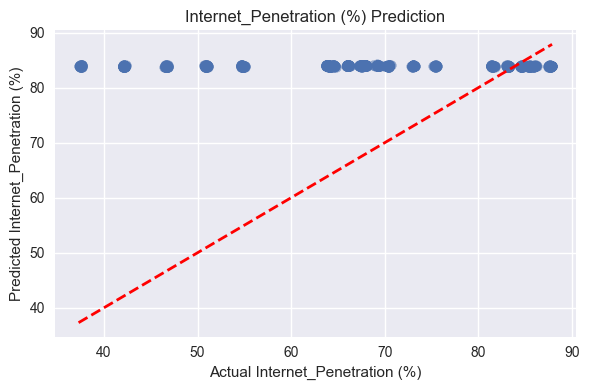


RandomForestRegressor (E_Commerce_Penetration (%)):
MSE: 624.5052, MAE: 22.1300, R²: -0.2524


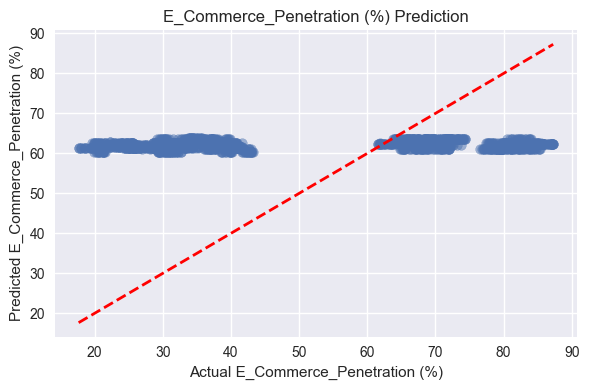

In [8]:
# Split data (recreate test set)
from sklearn.model_selection import train_test_split
_, X_temp, _, y_internet_temp = train_test_split(X, y_internet, test_size=0.3, random_state=42)
X_test, _, y_internet_test, _ = train_test_split(X_temp, y_internet_temp, test_size=0.33, random_state=42)
_, _, _, y_ecommerce_temp = train_test_split(X, y_ecommerce, test_size=0.3, random_state=42)
_, _, y_ecommerce_test, _ = train_test_split(X_temp, y_ecommerce_temp, test_size=0.33, random_state=42)

# Load optimized models
rf_internet = joblib.load('rf_internet_optimized.pkl')
rf_ecommerce = joblib.load('rf_ecommerce_optimized.pkl')

# Evaluate on test set
def evaluate_model(model, X_test, y_test, target_name):
    y_pred = model.predict(X_test)
    metrics = {
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }
    print(f"\n{model.__class__.__name__} ({target_name}):")
    print(f"MSE: {metrics['MSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R²']:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.title(f'{target_name} Prediction')
    plt.tight_layout()
    plt.show()
    
    return metrics

# Evaluate both models
internet_metrics = evaluate_model(rf_internet, X_test, y_internet_test, 'Internet_Penetration (%)')
ecommerce_metrics = evaluate_model(rf_ecommerce, X_test, y_ecommerce_test, 'E_Commerce_Penetration (%)')

## Model Optimization

In [9]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_temp, y_internet_train, y_internet_temp = train_test_split(X, y_internet, test_size=0.3, random_state=42)
X_val, X_test, y_internet_val, y_internet_test = train_test_split(X_temp, y_internet_temp, test_size=0.33, random_state=42)
_, _, y_ecommerce_train, y_ecommerce_temp = train_test_split(X, y_ecommerce, test_size=0.3, random_state=42)
_, _, y_ecommerce_val, y_ecommerce_test = train_test_split(X_temp, y_ecommerce_temp, test_size=0.33, random_state=42)

# Hyperparameter grid for Random Forest
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt']
}

# Optimize model
def optimize_model(X_train, y_train, X_val, y_val, target_name):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(rf, rf_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_val)
    metrics = {
        'MSE': mean_squared_error(y_val, y_pred),
        'MAE': mean_absolute_error(y_val, y_pred),
        'R²': r2_score(y_val, y_pred)
    }
    print(f"\nOptimized Random Forest ({target_name}):")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"MSE: {metrics['MSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R²']:.4f}")
    return best_rf, metrics

# Train Random Forest
rf_internet, internet_metrics = optimize_model(X_train, y_internet_train, X_val, y_internet_val, 'Internet_Penetration (%)')
rf_ecommerce, ecommerce_metrics = optimize_model(X_train, y_ecommerce_train, X_val, y_ecommerce_val, 'E_Commerce_Penetration (%)')

# Stacking with Random Forest and XGBoost
def train_stacking(X_train, y_train, X_val, y_val, target_name, rf_model):
    estimators = [('rf', rf_model), ('xgb', XGBRegressor(random_state=42, n_jobs=-1))]
    stack = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=42))
    stack.fit(X_train, y_train)
    y_pred = stack.predict(X_val)
    metrics = {
        'MSE': mean_squared_error(y_val, y_pred),
        'MAE': mean_absolute_error(y_val, y_pred),
        'R²': r2_score(y_val, y_pred)
    }
    print(f"\nStacking Regressor ({target_name}):")
    print(f"MSE: {metrics['MSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R²']:.4f}")
    return stack, metrics

# Train stacking
stack_internet, stack_internet_metrics = train_stacking(X_train, y_internet_train, X_val, y_internet_val, 'Internet_Penetration (%)', rf_internet)
stack_ecommerce, stack_ecommerce_metrics = train_stacking(X_train, y_ecommerce_train, X_val, y_ecommerce_val, 'E_Commerce_Penetration (%)', rf_ecommerce)

# Save models
joblib.dump(rf_internet, 'rf_internet_optimized.pkl')
joblib.dump(rf_ecommerce, 'rf_ecommerce_optimized.pkl')
joblib.dump(stack_internet, 'stack_internet.pkl')
joblib.dump(stack_ecommerce, 'stack_ecommerce.pkl')


Optimized Random Forest (Internet_Penetration (%)):
Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
MSE: 0.2257, MAE: 0.3214, R²: 0.9989

Optimized Random Forest (E_Commerce_Penetration (%)):
Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
MSE: 0.0144, MAE: 0.0450, R²: 1.0000

Stacking Regressor (Internet_Penetration (%)):
MSE: 0.0274, MAE: 0.0945, R²: 0.9999

Stacking Regressor (E_Commerce_Penetration (%)):
MSE: 0.0109, MAE: 0.0534, R²: 1.0000


['stack_ecommerce.pkl']

## Feature Importance Analysis

SHAP for Internet Penetration (%):


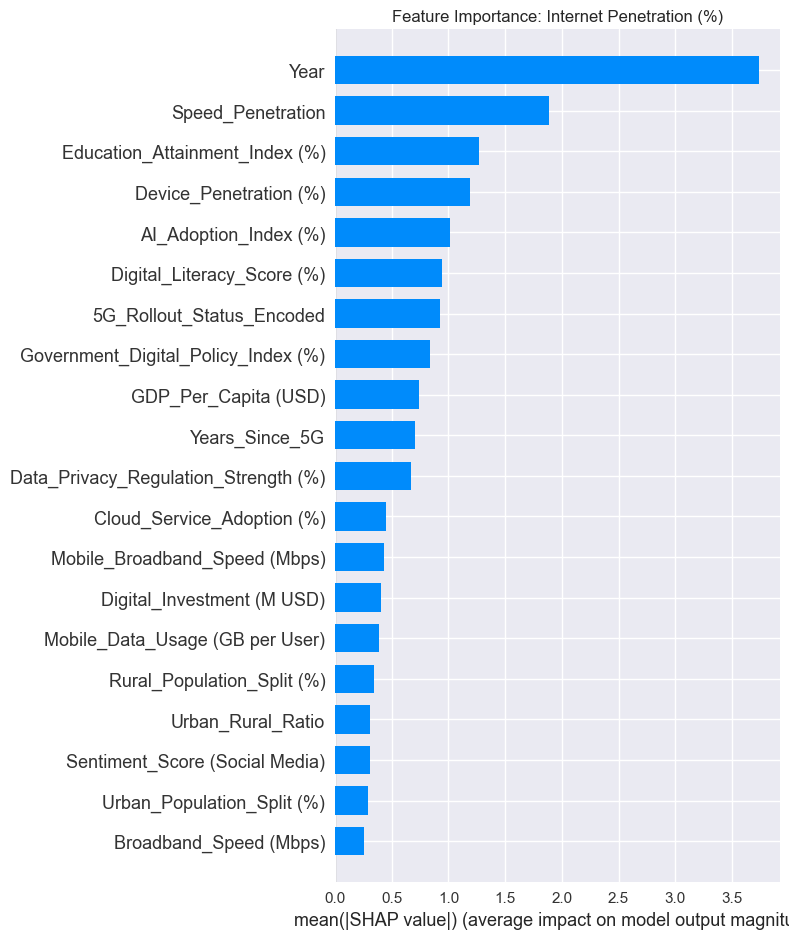


SHAP for E-Commerce Penetration (%):


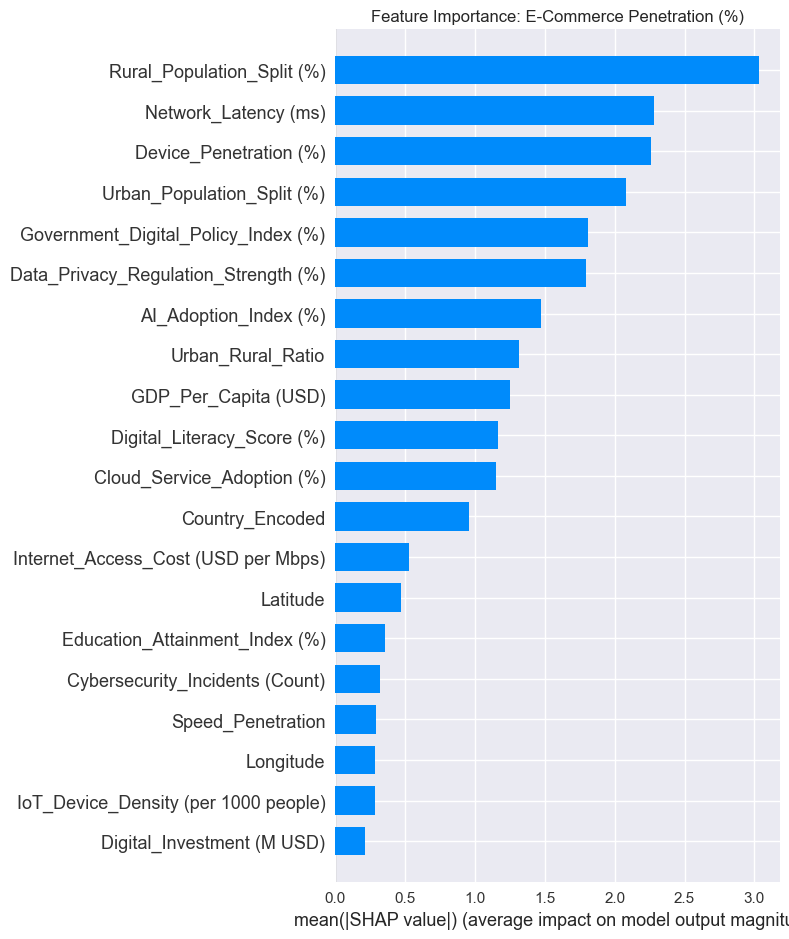

In [10]:
# SHAP for Internet Penetration
print("SHAP for Internet Penetration (%):")
explainer_internet = shap.TreeExplainer(rf_internet)
shap_values_internet = explainer_internet.shap_values(X_val)
plt.figure()
shap.summary_plot(shap_values_internet, X_val, plot_type="bar", show=False)
plt.title("Feature Importance: Internet Penetration (%)")
plt.tight_layout()
plt.show()

# SHAP for E-Commerce Penetration
print("\nSHAP for E-Commerce Penetration (%):")
explainer_ecommerce = shap.TreeExplainer(rf_ecommerce)
shap_values_ecommerce = explainer_ecommerce.shap_values(X_val)
plt.figure()
shap.summary_plot(shap_values_ecommerce, X_val, plot_type="bar", show=False)
plt.title("Feature Importance: E-Commerce Penetration (%)")
plt.tight_layout()
plt.show()

## Model Testing


RandomForestRegressor (Internet_Penetration (%)):
MSE: 0.2176, MAE: 0.3151, R²: 0.9989


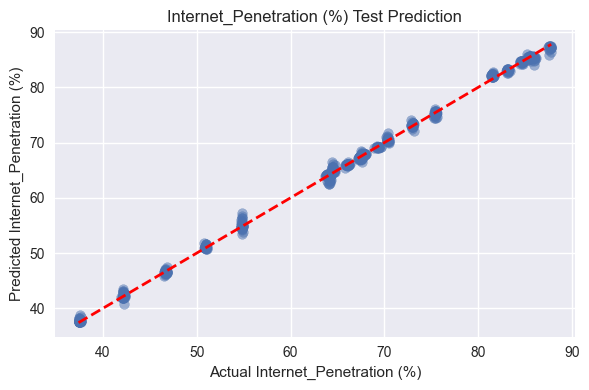


RandomForestRegressor (E_Commerce_Penetration (%)):
MSE: 0.0131, MAE: 0.0450, R²: 1.0000


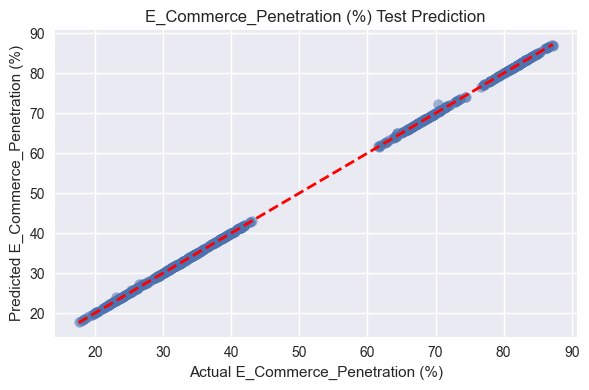

In [11]:
# Evaluate on test set
def test_model(model, X_test, y_test, target_name):
    y_pred = model.predict(X_test)
    metrics = {
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }
    print(f"\nRandomForestRegressor ({target_name}):")
    print(f"MSE: {metrics['MSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R²']:.4f}")
    
    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.title(f'{target_name} Test Prediction')
    plt.tight_layout()
    plt.show()
    
    return metrics

# Test both models
internet_metrics = test_model(rf_internet, X_test, y_internet_test, 'Internet_Penetration (%)')
ecommerce_metrics = test_model(rf_ecommerce, X_test, y_ecommerce_test, 'E_Commerce_Penetration (%)')

## Interactive Dashboard

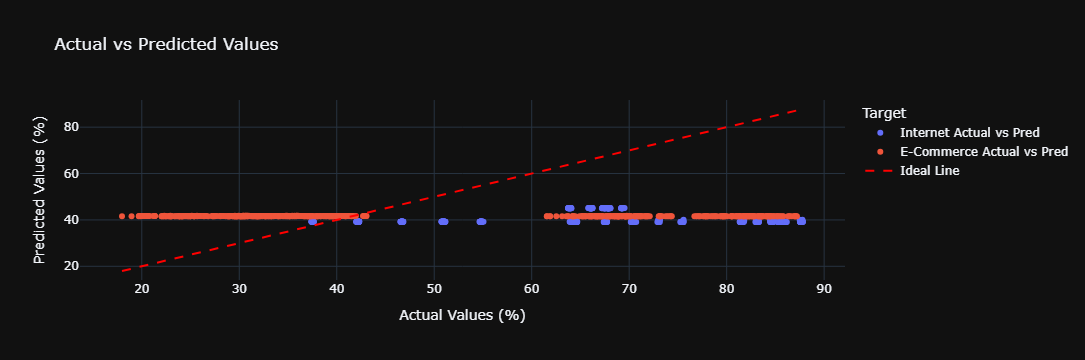

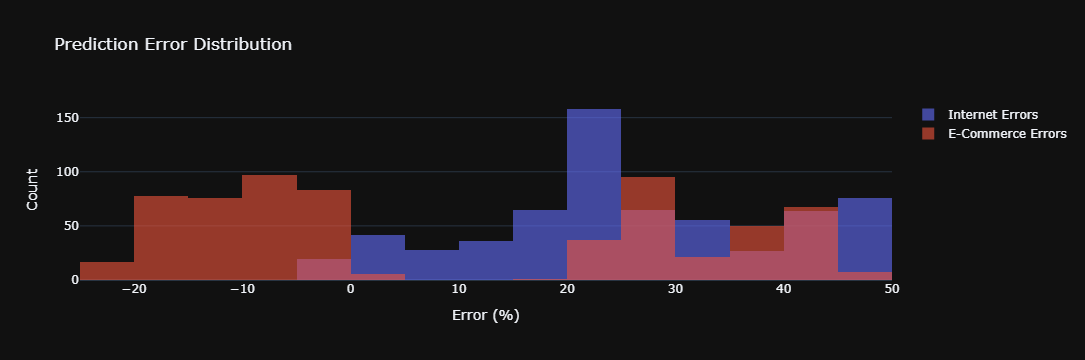

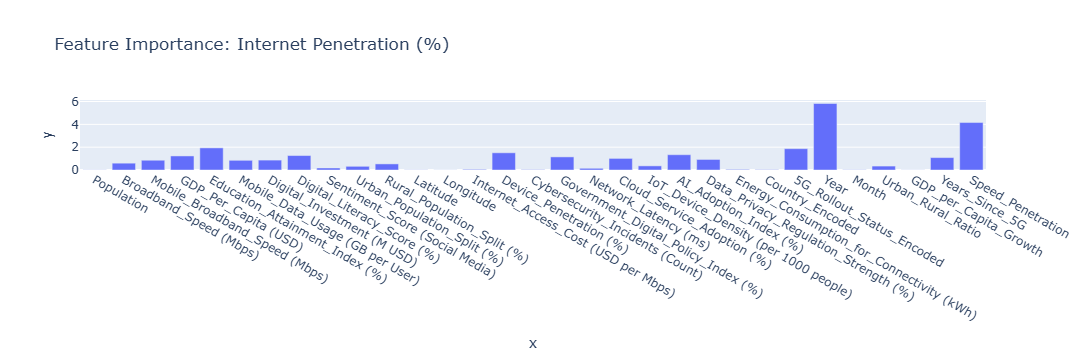

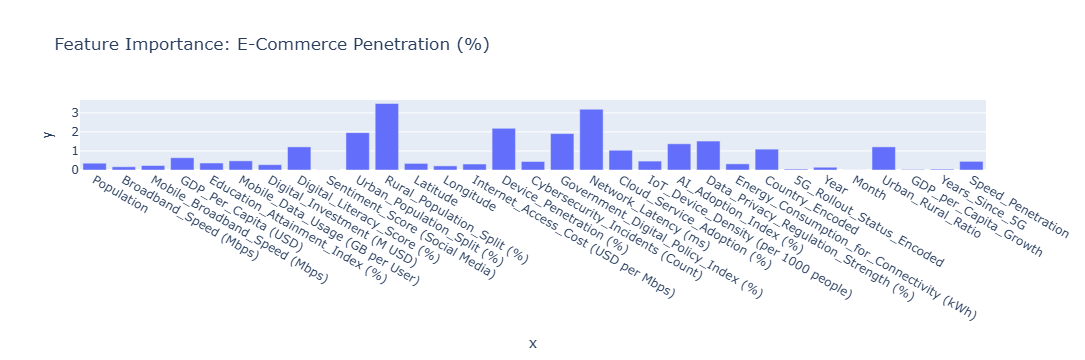

In [13]:
# Dashboard: Actual vs Predicted
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_internet_test, y=y_internet_pred, mode='markers', name='Internet Actual vs Pred'))
fig.add_trace(go.Scatter(x=y_ecommerce_test, y=y_ecommerce_pred, mode='markers', name='E-Commerce Actual vs Pred'))
fig.add_trace(go.Scatter(x=[min(y_internet_test.min(), y_ecommerce_test.min()), max(y_internet_test.max(), y_ecommerce_test.max())],
                         y=[min(y_internet_test.min(), y_ecommerce_test.min()), max(y_internet_test.max(), y_ecommerce_test.max())],
                         mode='lines', name='Ideal Line', line=dict(color='red', dash='dash')))
fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values (%)',
    yaxis_title='Predicted Values (%)',
    legend_title='Target',
    template='plotly_dark'
)
fig.show()

# Error Distribution
internet_errors = y_internet_test - y_internet_pred
ecommerce_errors = y_ecommerce_test - y_ecommerce_pred
fig_error = go.Figure()
fig_error.add_trace(go.Histogram(x=internet_errors, name='Internet Errors', opacity=0.6))
fig_error.add_trace(go.Histogram(x=ecommerce_errors, name='E-Commerce Errors', opacity=0.6))
fig_error.update_layout(
    title='Prediction Error Distribution',
    xaxis_title='Error (%)',
    yaxis_title='Count',
    barmode='overlay',
    template='plotly_dark'
)
fig_error.show()

# SHAP Feature Importance
explainer_internet = shap.TreeExplainer(rf_internet)
shap_values_internet = explainer_internet.shap_values(X_test_scaled)
fig_shap_internet = px.bar(x=X.columns, y=abs(shap_values_internet).mean(0), title='Feature Importance: Internet Penetration (%)')
fig_shap_internet.show()

explainer_ecommerce = shap.TreeExplainer(rf_ecommerce)
shap_values_ecommerce = explainer_ecommerce.shap_values(X_test_scaled)
fig_shap_ecommerce = px.bar(x=X.columns, y=abs(shap_values_ecommerce).mean(0), title='Feature Importance: E-Commerce Penetration (%)')
fig_shap_ecommerce.show()